# Analysing the contributions to the SHAP value (patient vs hospital, and main effect vs interactions)

**Research question: What contribution of the SHAP subset value comes from main effect vs interaction? What contribution of the SHAP value comes from the patient, hospital and patient-hospital interaction?**

## Plain English summary

In this notebook we will use the data from notebook 03f to understand how much of the contribution to the final SHAP value comes from various sources. Looking at either the split between the main effects and interactions, or the split between the subsets of features (being patient, hospital and the patient-hospital interactions).

In notebook 03g we split the features into two subsets: the hospital features, and patient features, and calculated the *subset* SHAP values for each feature. These will only include the SHAP interactions for the features that are in the same regression (so the main effect and the interactions that are with the other features in the multiple regression). This will exclude any SHAP interactions that are between the hostpial features and patient features.

The 10 features in the model can be classified as either those that are describing the patients characteristics (the “patient descriptive features”) or those that are describing the hospital’s processes (the “hospital descriptive features”). There are eight patient descriptive features (age, stroke severity, prior disability, onset-to-arrival time, stroke type, type of onset time, anticoagulants, and onset during sleep) and there are two hospital descriptive features (arrival-to-scan time, and hospital attended). For this analysis, we only included the single one-hot encoded feature for the attended hospital (and did not include the other 131 one-hot encoded features for the unattended hospitals). We calculated the subset SHAP value for each feature by only including the components of it's SHAP value that exclusively contain the effect from the features in the same subset. This is expressed as the sum of the main effect and the interaction effects with the other features within it’s subset. For the feature “arrival to scan”, which is part of the hospital descriptive subset, its subset SHAP value is the main effect plus the interaction with the feature hospital attended. For each of the features in the patient descriptive subset, its subset SHAP value is the main effect plus the sum of the interactions with each of the other seven patient descriptive features. For each set of descriptive features (hospital and patient) we fitted a multiple regression to predict the hospitals observed thrombolysis rate from the mean subset SHAP value of each feature for patients attending each hospital (using values from the all data model).

SHAP values are in the same units as the model output (for XGBoost these are in log odds). 

## Model and data

Using the XGBoost model trained on all of the data (no test set used) from notebook 03a_xgb_combined_shap_key_features.ipynb. The 10 features in the model are:

* Arrival-to-scan time: Time from arrival at hospital to scan (mins)
* Infarction: Stroke type (1 = infarction, 0 = haemorrhage)
* Stroke severity: Stroke severity (NIHSS) on arrival
* Precise onset time: Onset time type (1 = precise, 0 = best estimate)
* Prior disability level: Disability level (modified Rankin Scale) before stroke
* Stroke team: Stroke team attended
* Use of AF anticoagulents: Use of atrial fibrillation anticoagulant (1 = Yes, 0 = No)
* Onset-to-arrival time: Time from onset of stroke to arrival at hospital (mins)
* Onset during sleep: Did stroke occur in sleep?
* Age: Age (as middle of 5 year age bands)

And one target feature:
* Thrombolysis: Did the patient receive thrombolysis (0 = No, 1 = Yes)

## Aims

* Using XGBoost model fitted on all the data (no test set) using 10 features
* Using SHAP interaction values calculate subset SHAP values
* Analyse the contribution to the SHAP value from:
    * main effect vs interactions
    * patient subset, hospital subset and patient-hospital interactions
* Calculate in two ways:
    * sum of absolute
    * absolute of sum

## Observations

When using subsets of features the contribution to the total SHAP was found to be:

* Patient main and effects and interactions: 66%
* Hospital main and effects and interactions: 21%
* Hospital-patient interactions: 13%

These results are based on the sum of the absolute SHAP values for all features and interactions (the absolute value of the sum of features and interactions is also calculated in this notebook).

Note: This is different to asking about the contribution to between-hopsital variation. For example, the type of stroke (haemorrhagic vs. ischaemic) is an important contributor to the decision to give thrombolysis or not, but does not contribute signficantly to variation in thrombolysis use between hopsitals (as all hopsitals agree that haemorrhagic strokes should not receive thrombolysis, though hospitals may vary in their view on the suitability of ischaemic strokes to receive thrombolysis).


## Import libraries

In [1]:
# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Import machine learning methods
from xgboost import XGBClassifier

# Import shap for shapley values
import shap

from scipy import stats
from sklearn import linear_model

import os
import pickle

# .floor and .ceil
import math

# So can take deep copy
import copy

from os.path import exists
import json

## Set filenames

In [2]:
# Set up strings (describing the model) to use in filenames
number_of_features_to_use = 10
model_text = f'xgb_{number_of_features_to_use}_features'
notebook = '03g'

## Create output folders if needed

In [3]:
path = './saved_models'
if not os.path.exists(path):
    os.makedirs(path)

path = './output'
if not os.path.exists(path):
    os.makedirs(path)
    
path = './predictions'
if not os.path.exists(path):
    os.makedirs(path)   

## XGBoost model
Values used in this notebook are from an XGBoost model trained on the full dataset (rather than train/test splits used to assess accuracy) in notebook 03a. These models are saved f'./saved_models/03a_{model_text}.p'.

## Read in the prepared the data

Read in dictionary of dataframes, created in notebook 03f.

Each dataframe contains a different version of the SHAP value, a value per feature, per instance.

None of the SHAP values contain the contribution from unattended hostpials (each patient attends one hospital, for each patient remove the SHAP values for the one-hot encoded hosptial features that are not for the attended hospital, so only have the one-hot encoded hospital attended).

The five different SHAP values are:
* SHAP value (sum of row)
* main effect (diagonal value)
* SHAP interactions with other features within multiple regression feature set (per feature row, the columns of the other in regression features)
* SHAP interactions with other features outside multiple regression feature set (per feature row, the columns of the features not in the regression)
* SHAP subset value (main effect + SHAP values within = array(2) + array(3)

A features subset SHAP value is made up of its main effect value the interactions with the other features that are defined to be within their subset.
For our case, we have two subsets: patient and hospital. We will define these below.

In [4]:
# Setup dictionary for the five dataframe (using key to access them dynamically
filename = (f'./output/03f_{model_text}_'
            f'dict_of_shap_subset_values_dataframes.p') 

# load dictionary of dataframes from pickle
with open(filename, 'rb') as filehandler:
    dict_shap_instance_df = pickle.load(filehandler)
    
df_hosp_shap_values_without_unattended_hosp = (
                dict_shap_instance_df["without_unattended_hosp"])
df_hosp_shap_main_effects = (
                dict_shap_instance_df["main_effects"])
df_hosp_shap_interactions_within = (
                dict_shap_instance_df["interactions_within"])
df_hosp_shap_interactions_outside = (
                dict_shap_instance_df["interactions_outside"])
df_hosp_subset_shap_values = (
                dict_shap_instance_df["subset_shap_values"])

#### Define the two subset of features. 

Define the features as either 1) patient or 2) hospital features

In [5]:
patient_features = ['Infarction','Stroke severity',
                    'Precise onset time','Prior disability level',
                    'Use of AF anticoagulants','Onset-to-arrival time',
                    'Onset during sleep','Age']

hospital_features = ['Arrival-to-scan time','Stroke team']

## Contribution to SHAP values

Here we look at the magnitude of the contribution from the SHAP main effect vs the SHAP interaction for the patient subset SHAP and hospital subset SHAP.

### Calculate the sum of the absolute interactions

sum(|main|) + sum(|interaction|)

Get data for the two subsets of features: patient subset and hospital subset

In [6]:
# 1. The patient features

# for patient features sum the absolute values of their main effect
total_of_abs_p_main_per_instance = (np.abs(
            df_hosp_shap_main_effects[patient_features]).sum(axis=(1)))
# for patient features sum the absolute values of their interactions (with 
#   other patient features)
total_of_abs_p_interaction_per_instance = (np.abs(
            df_hosp_shap_interactions_within[patient_features]).sum(axis=(1)))
# sum of the absolute patient subset SHAP values
total_of_abs_p_subset_shap_per_instance = (total_of_abs_p_main_per_instance + 
                                total_of_abs_p_interaction_per_instance)

# proportion of patient contributions from interactions
proportion_of_abs_subset_shap_p_from_interactions_per_instance = (
                                total_of_abs_p_interaction_per_instance/
                                total_of_abs_p_subset_shap_per_instance)

# 2. The hospital features

# for hospital features sum the absolute values of their main effect
total_of_abs_h_main_per_instance = (np.abs(
            df_hosp_shap_main_effects[hospital_features]).sum(axis=(1)))
# for hospital features sum the absolute values of their interactions (with 
#   other hospital features)
total_of_abs_h_interaction_per_instance = (np.abs(
            df_hosp_shap_interactions_within[hospital_features]).sum(axis=(1)))
# sum of the absolute hospital subset SHAP values
total_of_abs_h_subset_shap_per_instance = (total_of_abs_h_main_per_instance + 
                                total_of_abs_h_interaction_per_instance)

# proportion of hospital contributions from interactions
proportion_of_abs_subset_shap_h_from_interactions_per_instance = (
                                total_of_abs_h_interaction_per_instance/
                                total_of_abs_h_subset_shap_per_instance)

#### Histograms of the contributions from main effect vs interactions (for the patient features, and the hospital features)

Define function to plot two histograms

In [7]:
def plot_two_histograms(patient_data, hospital_data, x_label_text):
    """
    Creates two subplots of histograms.
    
    patient_data [array]: continuous values,to be binned and used in LHS 
                          histogram
    hospital_data [array]: continuous values,to be binned and used in RHS 
                           histogram
    x_label_text [str]: text to use in x axis label
    return []: empty
    """
    
    # plot (histogram) the proportion of subset SHAP values from interactions
    bins = np.arange(0,1,0.05)

    fig = plt.figure(figsize=(10,5))

    # Plot patient contribution
    ax1 = fig.add_subplot(121)
    ax1.hist(proportion_of_abs_subset_shap_p_from_interactions_per_instance, 
             bins=bins);
    ax1.set_title("For patient features\nProportion of subset SHAP from "
                  "interactions\n(rest from main effect)")
    ax1.set_xlabel(f"Proportion of patient subset SHAP values from\n"
                   f"interactions, rest from main effect\n"
                   f"(calculated from {x_label_text} SHAP values)")
    ax1.set_ylabel("Number of instances")
    ax1.set_xlim(0, 1)
    ax1.set_ylim(0, 36000)

    # Plot hospital contribution
    ax2 = fig.add_subplot(122)
    ax2.hist(proportion_of_abs_subset_shap_h_from_interactions_per_instance, 
             bins=bins);
    ax2.set_title("For hospital features\nProportion of subset SHAP from "
                  "interactions\n(rest from main effect)")
    ax2.set_xlabel(f"Proportion of hospital subset SHAP values from\n"
                   f"interactions, rest from main effect\n"
                   f"(calculated from {x_label_text} SHAP values)")
    ax2.set_ylabel("Number of instances")
    ax2.set_xlim(0, 1)
    ax2.set_ylim(0, 36000)

    plt.tight_layout(pad=2)

    plt.show()
    
    return()

Plot the two histograms. 

For each instance, calculate the proportion of the SHAP value for all of the patient features that comes from the interactions (the rest comes from the main effect). 

Calculate by taking the sum of the absolute individual values.

Repeat for the RHS subplot showing the result for the hospital features.

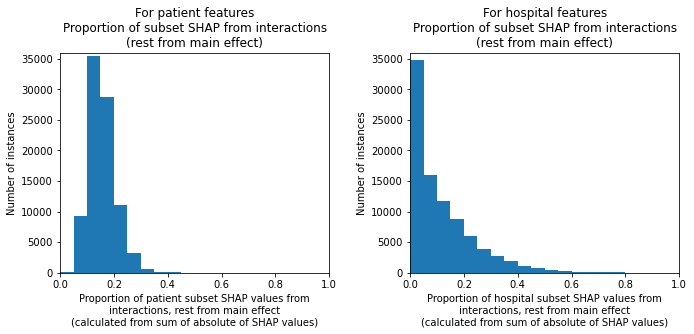

()

In [8]:
plot_two_histograms(
    proportion_of_abs_subset_shap_p_from_interactions_per_instance, 
    proportion_of_abs_subset_shap_h_from_interactions_per_instance,
    "sum of absolute of")

X axis, the 1 stands for all from interactions, and 0 stands for all from main effect. 

For the majority of patients, all hosptial contributions comes from main effect (either hosptial attended, or arrival to scan).

The main effect is also dominant for the patient contributions, but to a lesser extent than seen for the hosptial contribution.

#### SHAP contributions from patient, hospital and patient-hospital

Also calculate the sum of the patient-hospital interactions

In [9]:
# sum of the absolute patient-hospital interations
total_of_abs_hpph_contributions_per_instance = (
                        np.abs(df_hosp_shap_interactions_outside).sum(axis=(1)))

Create function to display proportions as a donut chart.

In [10]:
def plot_donut_chart(y, labels, filename):
    """
    create a pie chart and put a white circle in centre (a donut chart)
    
    y [array]: values for pie segments
    labels [list]: text for each pie segment
    return []: empty
    """
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot()

    # Plot pie chart
    ax.pie(y, labels=labels, autopct='%1.0f%%')

    # Add a circle at the center to transform it in a donut chart
    my_circle=plt.Circle( (0,0), 0.3, color='white')
    p=plt.gcf()
    p.gca().add_artist(my_circle)
    
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    
    plt.show();
    
    return()

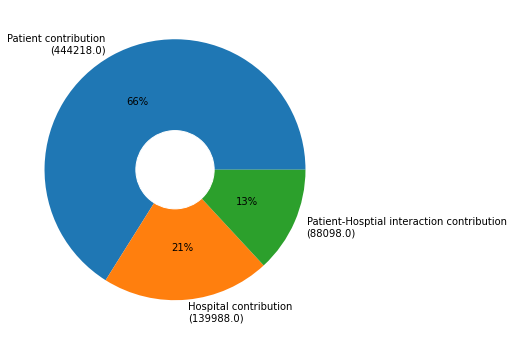

()

In [11]:
y = np.array([total_of_abs_p_subset_shap_per_instance.sum(), 
              total_of_abs_h_subset_shap_per_instance.sum(), 
              total_of_abs_hpph_contributions_per_instance.sum()])

mylabels = [f"Patient contribution\n("
            f"{round(total_of_abs_p_subset_shap_per_instance.sum(),0)})", 
            f"Hospital contribution\n("
            f"{round(total_of_abs_h_subset_shap_per_instance.sum(),0)})", 
            f"Patient-Hosptial interaction contribution\n("
            f"{round(total_of_abs_hpph_contributions_per_instance.sum(),0)})"]

filename = (f'./output/{notebook}_{model_text}_shap_contributions_sum_of_abs_'
            f'donut.jpg')

plot_donut_chart(y, mylabels, filename)

### Calculate the absolute of the sum

Repeat the above, this time calculating the absolute of the sum of the interactions 

|sum(main) + sum(interaction)|

Get data for the two subsets of features: patient subset and hospital subset

In [12]:
# 1. The patient features

# absolute of the sum of the individual main effect values
abs_of_total_p_main_per_instance = (np.abs(
            df_hosp_shap_main_effects[patient_features].sum(axis=(1))))

# absolute of the sum of the individual interaction values with other patient 
#   features
abs_of_total_p_interaction_per_instance = (np.abs(
            df_hosp_shap_interactions_within[patient_features].sum(axis=(1))))

# sum of patient contributions (main effect + subset interactions)
abs_of_total_p_subset_shap_per_instance = (
                abs_of_total_p_main_per_instance + 
                abs_of_total_p_interaction_per_instance)

# proportion of patient contributions from interactions
abs_of_total_p_interactions_proportion_per_instance = (
                abs_of_total_p_interaction_per_instance/
                abs_of_total_p_subset_shap_per_instance)

# 2. The hospital features

# absolute of the sum of the individual main effect values
abs_of_total_h_main_per_instance = (np.abs(
            df_hosp_shap_main_effects[hospital_features].sum(axis=(1))))

# absolute of the sum of the individual interaction values with other hospital
#   features
abs_of_total_h_interaction_per_instance = (np.abs(
            df_hosp_shap_interactions_within[hospital_features].sum(axis=(1))))

# sum of hospital contributions (main effect + subset interactions)
abs_of_total_h_subset_shap_per_instance = (
                                    abs_of_total_h_main_per_instance + 
                                    abs_of_total_h_interaction_per_instance)

# proportion of hospital contributions from interactions
abs_of_total_h_interactions_proportion_per_instance = (
                                abs_of_total_h_interaction_per_instance/
                                abs_of_total_h_subset_shap_per_instance)

#### SHAP contributions from main effect vs interactions (for patient features, and hospital features)

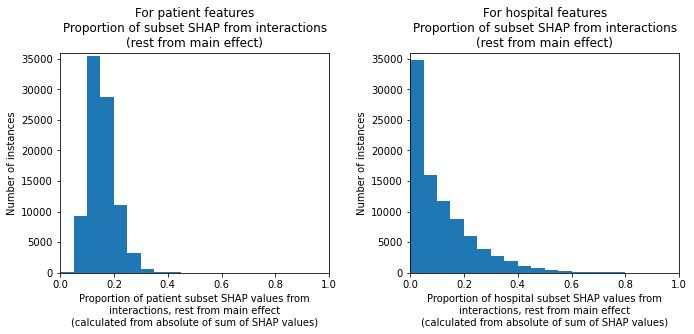

()

In [13]:
plot_two_histograms(
    abs_of_total_p_interactions_proportion_per_instance, 
    abs_of_total_h_interactions_proportion_per_instance,
    "absolute of sum of")

#### SHAP contributions from patient, hospital and patient-hospital

Also calculate the sum of the patient-hospital interactions

In [14]:
# for hospital-patient features
abs_of_total_hpph_contributions_per_instance = (
                        np.abs(df_hosp_shap_interactions_outside.sum(axis=(1))))

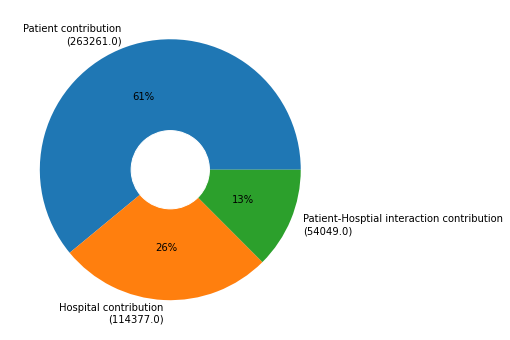

()

In [15]:
y = np.array([abs_of_total_p_subset_shap_per_instance.sum(), 
              abs_of_total_h_subset_shap_per_instance.sum(), 
              abs_of_total_hpph_contributions_per_instance.sum()])

mylabels = [f"Patient contribution\n("
            f"{round(abs_of_total_p_subset_shap_per_instance.sum(),0)})", 
            f"Hospital contribution\n("
            f"{round(abs_of_total_h_subset_shap_per_instance.sum(),0)})", 
            f"Patient-Hosptial interaction contribution\n("
            f"{round(abs_of_total_hpph_contributions_per_instance.sum(),0)})"]

filename = (f'./output/{notebook}_{model_text}_shap_contributions_abs_of_sum_'
            f'donut.jpg')

plot_donut_chart(y, mylabels, filename)